In [16]:
!pip install pyclustering

^C


                                              0.0/2.6 MB ? eta -:--:--
     -                                        0.1/2.6 MB 3.6 MB/s eta 0:00:01
     -------------                            0.8/2.6 MB 10.8 MB/s eta 0:00:01
     ----------------                         1.0/2.6 MB 13.3 MB/s eta 0:00:01
     ----------------                         1.0/2.6 MB 13.3 MB/s eta 0:00:01
     ----------------                         1.0/2.6 MB 13.3 MB/s eta 0:00:01
     --------------------------------         2.1/2.6 MB 8.3 MB/s eta 0:00:01
     --------------------------------         2.1/2.6 MB 8.3 MB/s eta 0:00:01
     --------------------------------         2.1/2.6 MB 8.3 MB/s eta 0:00:01
     ---------------------------------------  2.6/2.6 MB 6.5 MB/s eta 0:00:01
     ---------------------------------------- 2.6/2.6 MB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyclustering: filename=


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
# clustering and dimension reduction
from pyclustering.cluster.kmeans import kmeans
from pyclustering import utils

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn as sk
from sklearn import metrics

from sklearn.metrics import silhouette_samples, silhouette_score

# para UMAP
import umap
import umap.plot

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import adjusted_rand_score

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import randint
import pandas as pd
import pickle
import seaborn as sns
import time

In [6]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.silhouette import silhouette

In [2]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [3]:
def leo_y_consolido_features(input_path='./input/'):
    df1 = pd.read_csv(input_path+'features_Arborio.csv')
    df2 = pd.read_csv(input_path+'features_Basmati.csv')
    df3 = pd.read_csv(input_path+'features_Ipsala.csv')
    df4 = pd.read_csv(input_path+'features_Jasmine.csv')
    df5 = pd.read_csv(input_path+'features_Karacadag.csv')
    features = np.array(pd.concat([df1,df2,df3,df4,df5], axis =0))
    return features

input_path = "G:/Mi unidad\Maestria Data Mining/2023Q2 DMCyT/unsupervised-rice-image-segmentation/Rice_Image_Dataset/"

x = leo_y_consolido_features(input_path=input_path)

In [29]:
def grafico_evaluacion(X_train_test, labels_orig, labels_test , nom_test=''):
    '''grafico en el espacio vectorial del pca las clasificaciones realizadas
    X_train_test = coordenadas de lso puntos en PCA -considera slo las primeras 4-
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo
    nom_test     = texto para aclara en el grafico el nombre del clasificador utilizado
    '''
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)

    fig, axs = plt.subplots(2,2)
    axs[0,0].scatter(X_train_test[:,0],X_train_test[:,1],s=1,c=labels_test, alpha=0.5, cmap=cmap)
    axs[0,0].set_xlabel('PC1')
    axs[0,0].set_ylabel('PC2')
    axs[0,1].scatter(X_train_test[:,2],X_train_test[:,3],s=1,c=labels_test, alpha=0.5, cmap=cmap)
    axs[0,1].set_xlabel('PC3')
    axs[0,1].set_ylabel('PC4')
    
    
    axs[1,0].scatter(X_train_test[:,0],X_train_test[:,1],s=1,c=labels_orig, alpha=0.5, cmap=cmap)
    axs[1,0].set_xlabel('PC1')
    axs[1,0].set_ylabel('PC2')
    axs[1,1].scatter(X_train_test[:,2],X_train_test[:,3],s=1,c=labels_orig, alpha=0.5, cmap=cmap)
    axs[1,1].set_xlabel('PC3')
    axs[1,1].set_ylabel('PC4')
    
    
    axs[0,0].set_title(f'{nom_test}')
    axs[0,1].set_title(f'{nom_test}')
    axs[1,0].set_title('real')
    axs[1,1].set_title('real')
    fig.set_constrained_layout('constrained')
    return None

def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = metrics.rand_score(Labels_orig, Labels_clust)
    arand= metrics.adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, cantidad_de_muestras={len(Labels_orig):,d}')
    return ct

#### Trabajo con el 20% (15 mil imagenes en lugar de las 75 mil) de los datos dado que Silhouette demora en correr

In [4]:
# como están ordenadas por clase voy a hacer una lista con las etiquetas ahora antes de mezclarlas
clases_dict = {0:'Arborio', 1:'Basmati', 2:'Ipsala', 3:'Jasmine', 4:'Karacadag'}
lista_clases = ([0]*15000 + [1]*15000 + [2]*15000 + [3]*15000 + [4]*15000)

# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(x, lista_clases, test_size=0.8, random_state=42)

org_lab = pd.Series(y_train_test).map(clases_dict)

### Reducción de dimensionalidad: PCA

In [74]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(X_train_test)

PCA(n_components=100, random_state=22)

Text(0.5, 1.0, 'Selección de número de componentes en PCA')

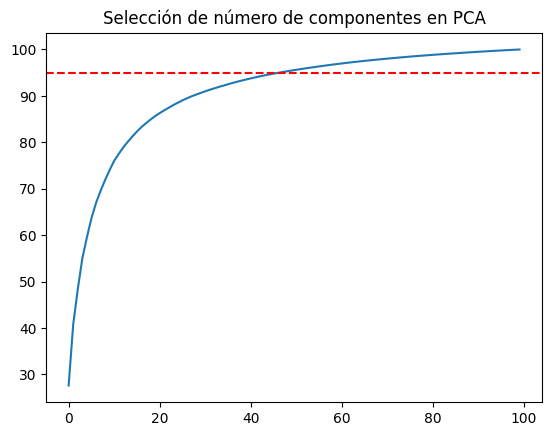

In [75]:
plt.plot(np.cumsum((pca.explained_variance_))/sum(pca.explained_variance_)*100)
plt.axhline(y= 95, color='r', linestyle='--')
#plt.axvline(x= 45, color='g', linestyle='--')
plt.title('Selección de número de componentes en PCA')

In [5]:
pca = PCA(n_components= 45, random_state=22)
pca.fit(X_train_test)
x_pca = pca.transform(X_train_test)

print(f"Components before PCA: {X_train_test.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 45


Text(0, 0.5, 'PC4')

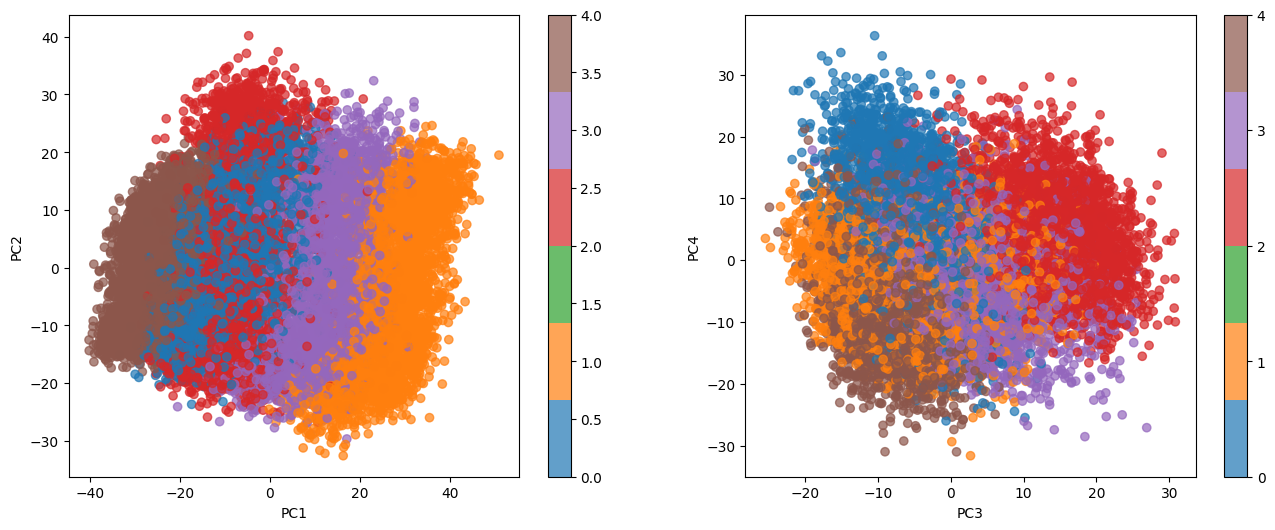

In [56]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab10(np.arange(6)), 6)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x_pca[:,0],x_pca[:,1],c=y_train_test,cmap=cmap, alpha=0.7)
plt.colorbar();
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.subplot(1,2,2)
plt.scatter(x_pca[:,2],x_pca[:,3],c=y_train_test,cmap=cmap, alpha=0.7)
plt.colorbar(ticks=range(6));
plt.xlabel('PC3')
plt.ylabel('PC4')


#### Tipos de distancia para el K_Means
* EUCLIDEAN = 0, EUCLIDEAN_SQUARE = 1, MANHATTAN = 2, CHEBYSHEV = 3, MINKOWSKI = 4
https://pyclustering.github.io/docs/0.8.2/html/da/d3a/classpyclustering_1_1utils_1_1metric_1_1type__metric.html


#### Para distancia Euclidea

Text(0, 0.5, 'SSE para KMeans (euclidea) con PCA')

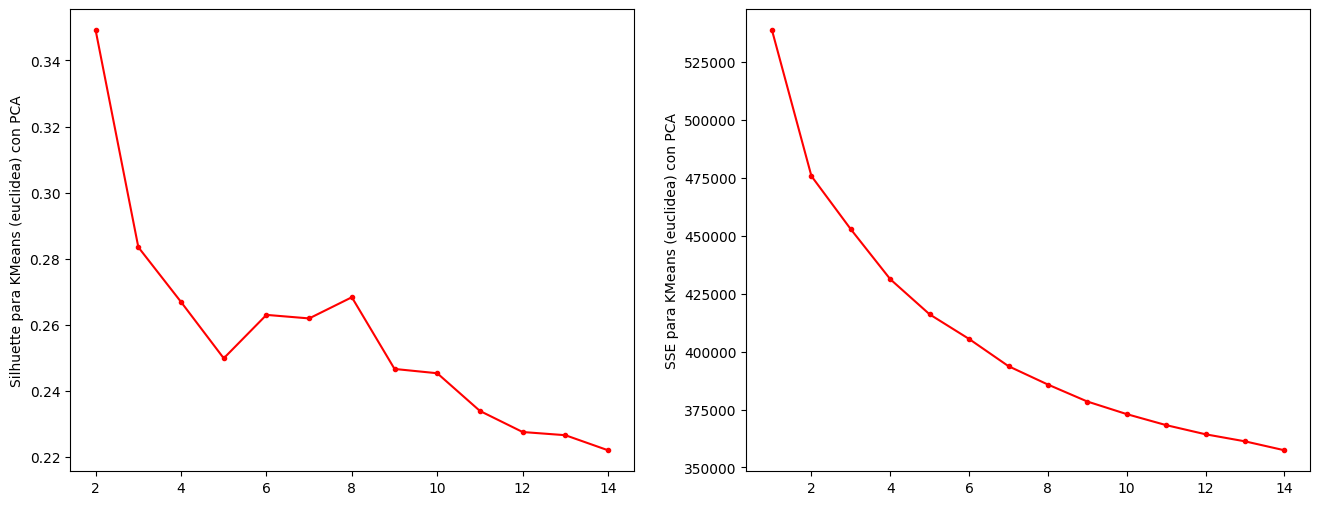

In [26]:
range_k = [i for i in range(1,15)]
silh_euc = []
sse_euc = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10)
    kmeans_centers.fit(x_pca)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.EUCLIDEAN)

    kmeans_instance = kmeans(x_pca, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_euc.append(np.mean(silhouette(x_pca, clusters).process().get_score()))
    sse_euc.append(kmeans_instance.get_total_wce())
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_euc,'r.-')
plt.ylabel('Silhuette para KMeans (euclidea) con PCA')
plt.subplot(1,2,2)
plt.plot(range_k,sse_euc,'r.-')
plt.ylabel('SSE para KMeans (euclidea) con PCA')

#### Para distancia Manhattan

Text(0, 0.5, 'SSE para KMeans (Manhattan) con PCA')

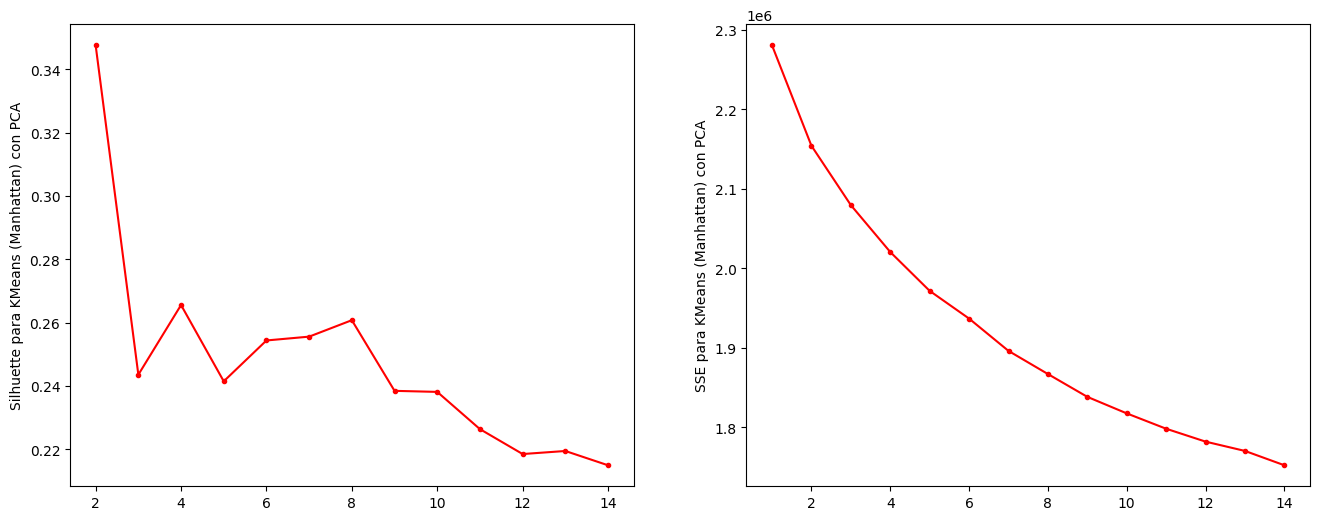

In [27]:
range_k = [i for i in range(1,15)]
silh_manh = []
sse_manh = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10)
    kmeans_centers.fit(x_pca)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.MANHATTAN)

    kmeans_instance = kmeans(x_pca, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_manh.append(np.mean(silhouette(x_pca, clusters).process().get_score()))
    sse_manh.append(kmeans_instance.get_total_wce())

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_manh,'r.-')
plt.ylabel('Silhuette para KMeans (Manhattan) con PCA')
plt.subplot(1,2,2)
plt.plot(range_k,sse_manh,'r.-')
plt.ylabel('SSE para KMeans (Manhattan) con PCA')

#### Para distancia Chebyshev

Text(0, 0.5, 'SSE para KMeans (Chebyshev) con PCA')

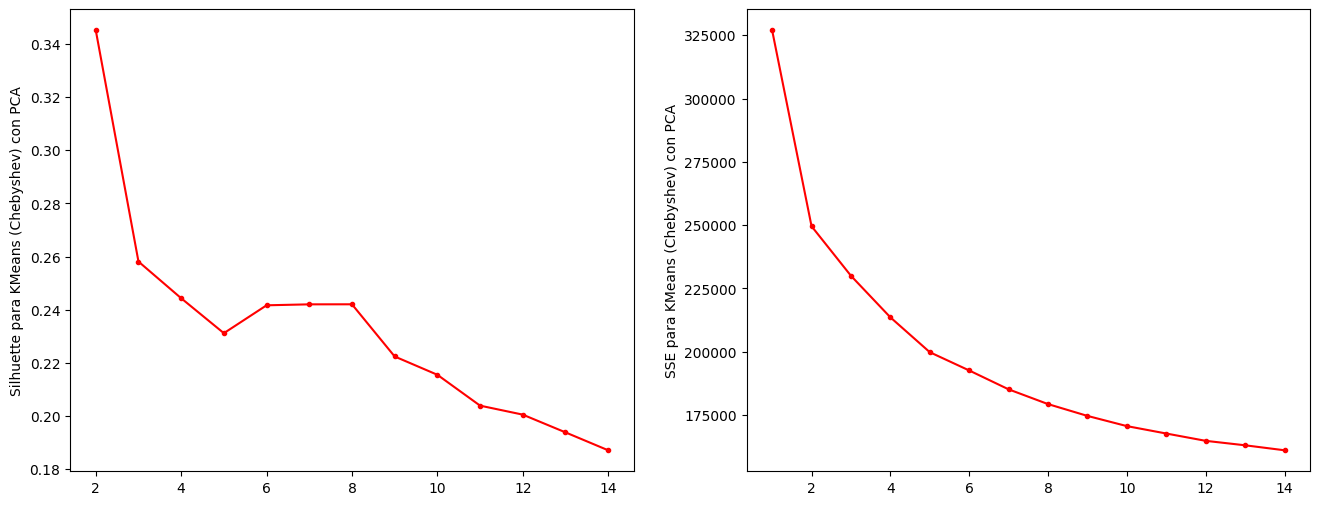

In [28]:
range_k = [i for i in range(1,15)]
silh_cheb = []
sse_cheb = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10)
    kmeans_centers.fit(x_pca)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.CHEBYSHEV)

    kmeans_instance = kmeans(x_pca, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_cheb.append(np.mean(silhouette(x_pca, clusters).process().get_score()))
    sse_cheb.append(kmeans_instance.get_total_wce())
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_cheb,'r.-')
plt.ylabel('Silhuette para KMeans (Chebyshev) con PCA')
plt.subplot(1,2,2)
plt.plot(range_k,sse_cheb,'r.-')
plt.ylabel('SSE para KMeans (Chebyshev) con PCA')

#### Pruebo opciones de k

n_clusters = 3 silhouette_score: 0.16032006812541724
n_clusters = 4 silhouette_score: 0.1550542300456675
n_clusters = 5 silhouette_score: 0.14485179822910763


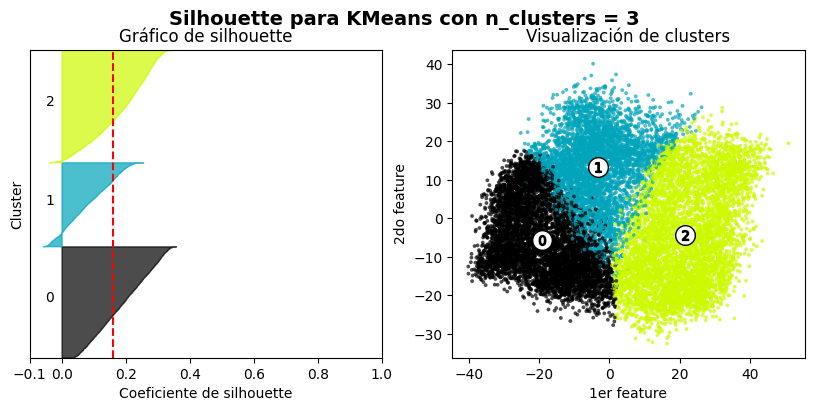

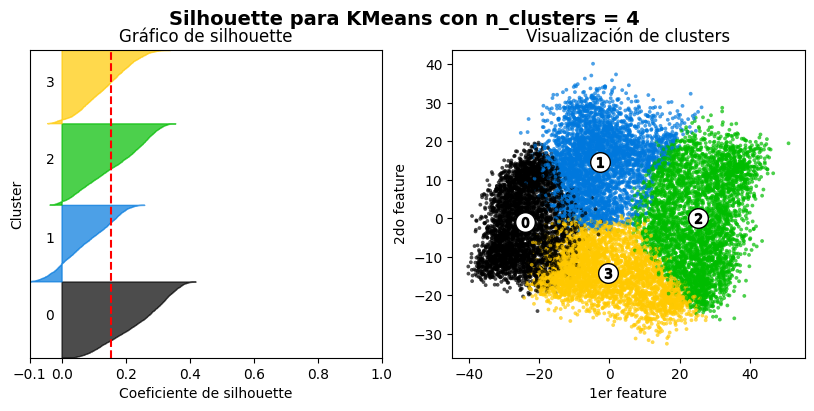

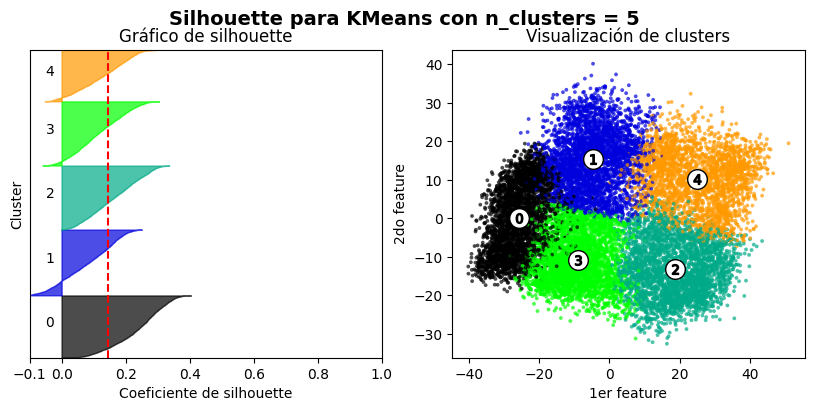

In [69]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = range(3,6)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(x_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_pca, cluster_labels)
    print(
        "n_clusters =",
        n_clusters,
        "silhouette_score:",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Gráfico de silhouette")
    ax1.set_xlabel("Coeficiente de silhouette")
    ax1.set_ylabel("Cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        x_pca[:, 0], x_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualización de clusters")
    ax2.set_xlabel("1er feature")
    ax2.set_ylabel("2do feature")

    plt.suptitle(
        "Silhouette para KMeans con n_clusters = %d"
        % n_clusters,
        fontsize=10,
        fontweight="bold",
    )

plt.show()

RAND score=0.8056, Ajusted RAND=0.3945, cantidad_de_muestras=15,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,306,0,13,1,2719
1,34,1747,12,1344,0
2,1440,0,1455,107,219
3,1234,24,1415,443,25
4,15,1345,3,1099,0


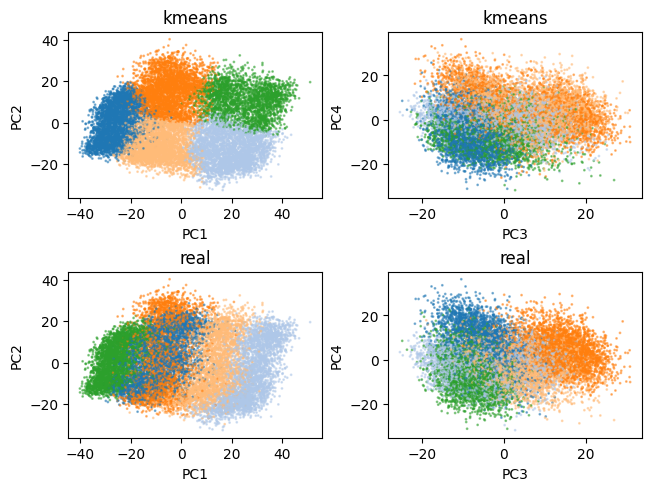

In [38]:
k= 5
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(x_pca)

grafico_evaluacion(x_pca, y_train_test, kmeans.labels_ , nom_test='kmeans')
cross_tab(org_lab, kmeans.labels_)

RAND score=0.7075, Ajusted RAND=0.2911, cantidad_de_muestras=15,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,618,590,1349,1125,3
1,193,2526,74,1836,0
2,2218,0,1475,33,2960


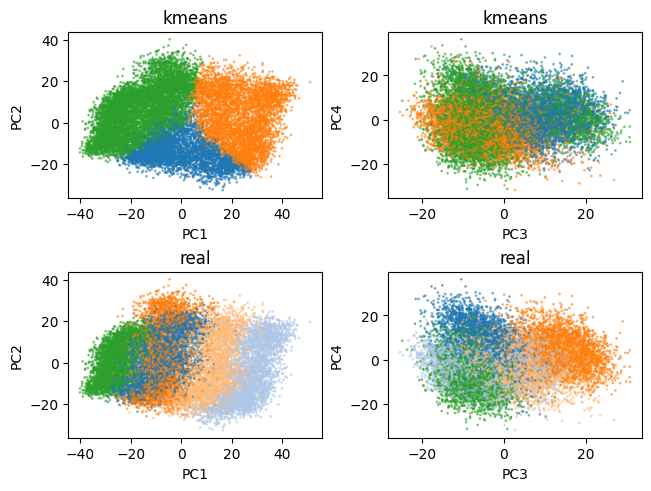

In [51]:
k= 3
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit(x_pca)

grafico_evaluacion(x_pca, y_train_test, kmeans.labels_ , nom_test='kmeans')
cross_tab(org_lab, kmeans.labels_)

#### Validación interna

In [52]:
vanDongen_table = []
Rand_table = []
n_clusters_table = range(2,10)

for i in n_clusters_table:
  kmeans_temp = KMeans(n_clusters=i)
  kmeans_temp.fit(x_pca)
  tmp_table = pd.DataFrame({'Predict': kmeans_temp.labels_, 'Real': org_lab})
  ct = pd.crosstab(tmp_table['Predict'], tmp_table['Real'])
  vanDongen_table.append(vanDongen(ct))
  Rand_table.append(adjusted_rand_score(kmeans_temp.labels_, org_lab))
  
pd.DataFrame({'vanDongen': vanDongen_table, 'Rand': Rand_table}, index=n_clusters_table)

,vanDongen,Rand
2,0.530216,0.319235
3,0.545831,0.331066
4,0.521119,0.367204
5,0.537584,0.397318
6,0.452664,0.435602
7,0.418009,0.456569
8,0.394322,0.473919
9,0.414661,0.429431


### Reducción de dimensionalidad: UMAP

<Axes: >

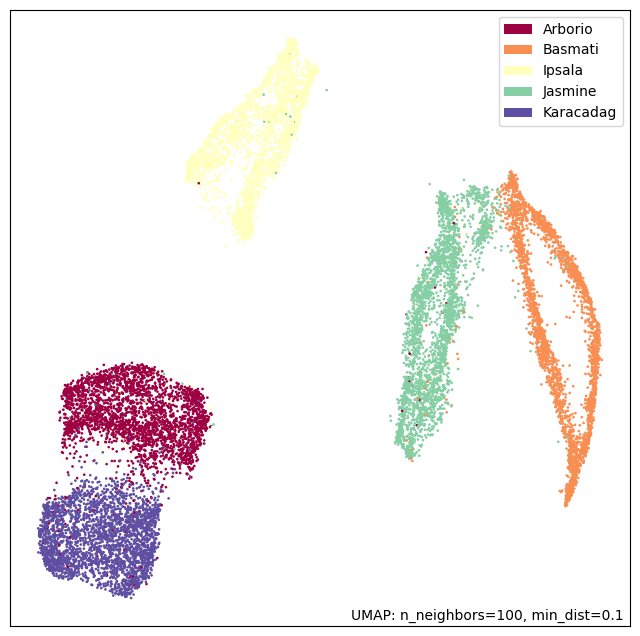

In [42]:
um = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean')
x_umap = um.fit_transform(X_train_test)

umap.plot.points(um, labels=org_lab)

In [ ]:
cross_tab(org_lab, kmeans.labels_)

#### Para distancia Euclidea

Text(0, 0.5, 'SSE para KMeans (euclidea) con PCA')

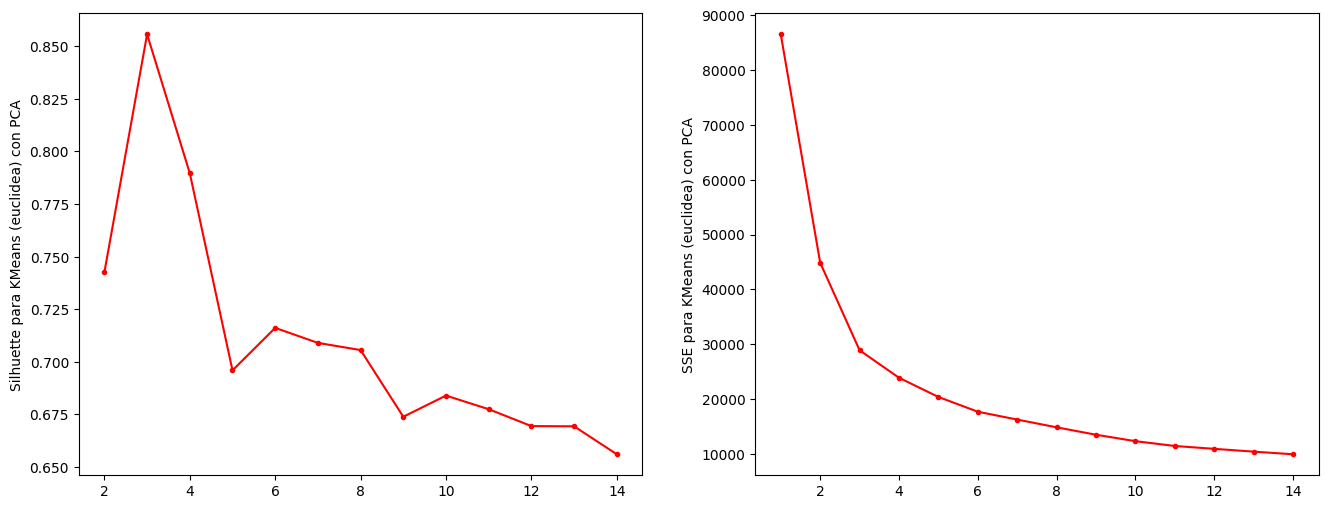

In [48]:
range_k = [i for i in range(1,15)]
silh_euc = []
sse_euc = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10)
    kmeans_centers.fit(x_umap)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.EUCLIDEAN)

    kmeans_instance = kmeans(x_umap, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_euc.append(np.mean(silhouette(x_umap, clusters).process().get_score()))
    sse_euc.append(kmeans_instance.get_total_wce())
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_euc,'r.-')
plt.ylabel('Silhuette para KMeans (euclidea) con PCA')
plt.subplot(1,2,2)
plt.plot(range_k,sse_euc,'r.-')
plt.ylabel('SSE para KMeans (euclidea) con PCA')

#### Para distancia Manhattan

Text(0, 0.5, 'SSE para KMeans (Manhattan) con PCA')

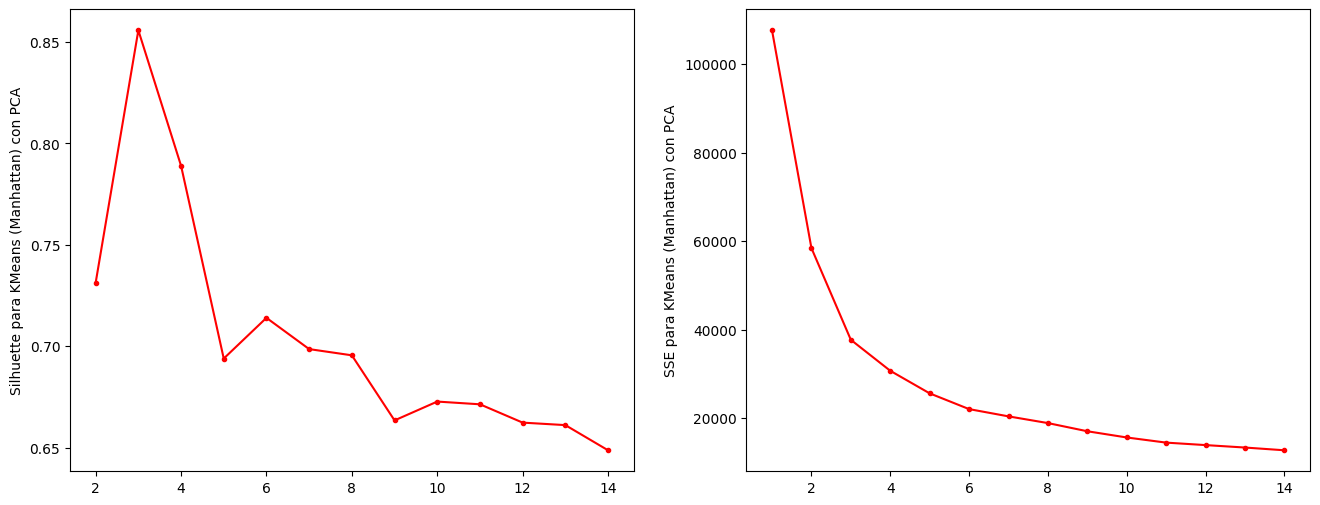

In [49]:
range_k = [i for i in range(1,15)]
silh_manh = []
sse_manh = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10)
    kmeans_centers.fit(x_umap)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.MANHATTAN)

    kmeans_instance = kmeans(x_umap, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_manh.append(np.mean(silhouette(x_umap, clusters).process().get_score()))
    sse_manh.append(kmeans_instance.get_total_wce())

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_manh,'r.-')
plt.ylabel('Silhuette para KMeans (Manhattan) con PCA')
plt.subplot(1,2,2)
plt.plot(range_k,sse_manh,'r.-')
plt.ylabel('SSE para KMeans (Manhattan) con PCA')

#### Para distancia Chebyshev

Text(0, 0.5, 'SSE para KMeans (Chebyshev) con PCA')

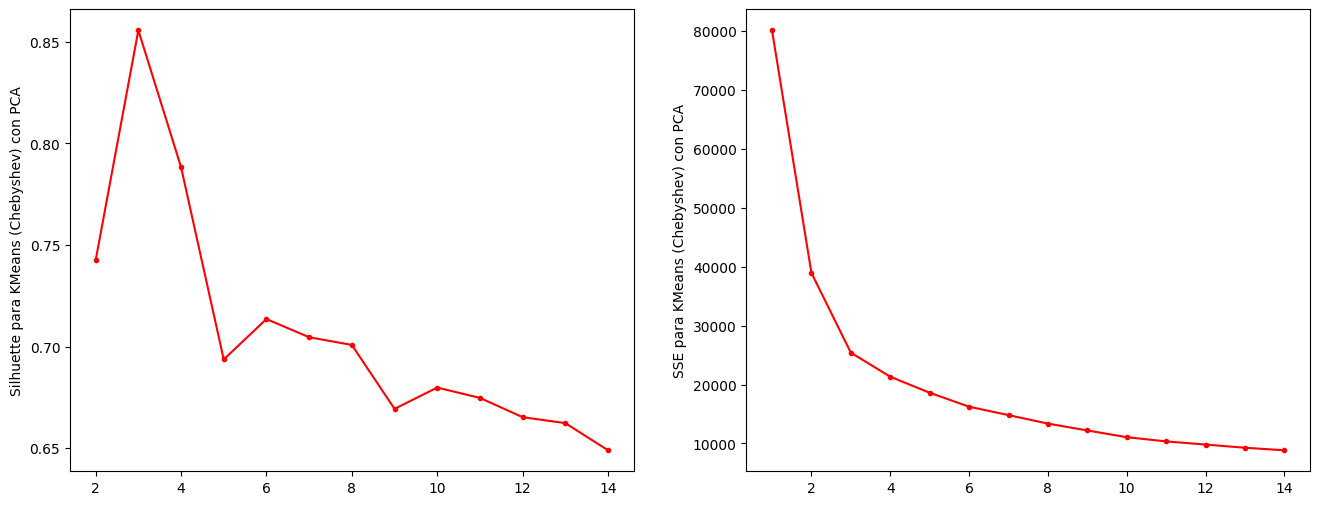

In [50]:
range_k = [i for i in range(1,15)]
silh_cheb = []
sse_cheb = []
for k in range_k:
    
    kmeans_centers = KMeans(n_clusters=k, random_state=10)
    kmeans_centers.fit(x_umap)
    centers = kmeans_centers.cluster_centers_

    metrica_elegida = distance_metric(type_metric.CHEBYSHEV)

    kmeans_instance = kmeans(x_umap, centers, metric=metrica_elegida);
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    
    silh_cheb.append(np.mean(silhouette(x_umap, clusters).process().get_score()))
    sse_cheb.append(kmeans_instance.get_total_wce())
    
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(range_k,silh_cheb,'r.-')
plt.ylabel('Silhuette para KMeans (Chebyshev) con PCA')
plt.subplot(1,2,2)
plt.plot(range_k,sse_cheb,'r.-')
plt.ylabel('SSE para KMeans (Chebyshev) con PCA')

n_clusters = 3 silhouette_score: 0.67067814
n_clusters = 4 silhouette_score: 0.6136842
n_clusters = 5 silhouette_score: 0.62854475


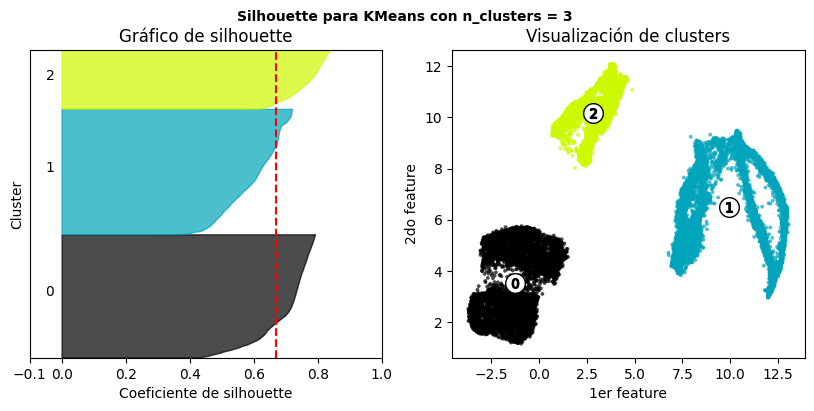

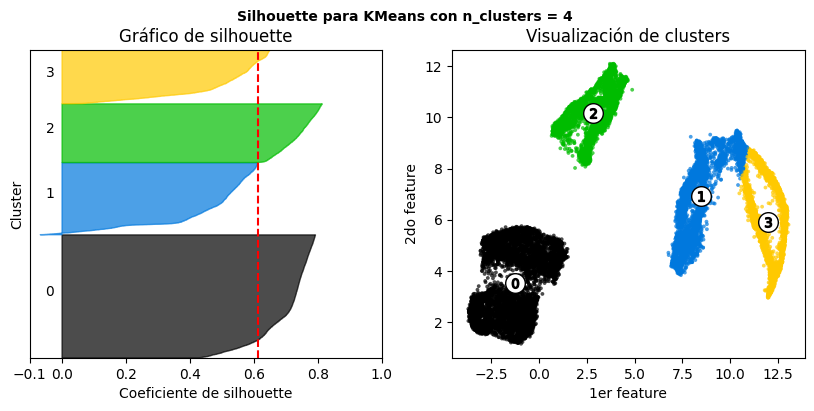

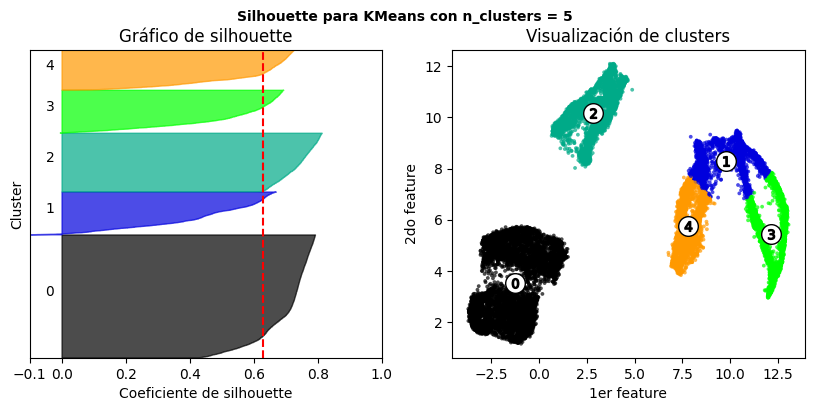

In [70]:
range_n_clusters = range(3,6)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_umap) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(x_umap)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_umap, cluster_labels)
    print(
        "n_clusters =",
        n_clusters,
        "silhouette_score:",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_umap, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Gráfico de silhouette")
    ax1.set_xlabel("Coeficiente de silhouette")
    ax1.set_ylabel("Cluster")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        x_umap[:, 0], x_umap[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualización de clusters")
    ax2.set_xlabel("1er feature")
    ax2.set_ylabel("2do feature")

    plt.suptitle(
        "Silhouette para KMeans con n_clusters = %d"
        % n_clusters,
        fontsize=10,
        fontweight="bold",
    )

plt.show()

#### Pruebo opciones de k

In [71]:
k= 3
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans_umap = kmeans.fit_predict(x_umap)

cross_tab(org_lab, kmeans.labels_)

RAND score=0.8316, Ajusted RAND=0.5974, cantidad_de_muestras=15,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,3012,0,27,14,2963
1,16,3116,20,2966,0
2,1,0,2851,14,0


In [72]:
k= 4
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans_umap = kmeans.fit_predict(x_umap)

cross_tab(org_lab, kmeans.labels_)

RAND score=0.9029, Ajusted RAND=0.7374, cantidad_de_muestras=15,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,16,3116,20,2966,0
1,2913,0,26,12,79
2,1,0,2851,14,0
3,99,0,1,2,2884


In [61]:
k= 5
kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans_umap = kmeans.fit_predict(x_umap)

cross_tab(org_lab, kmeans.labels_)

RAND score=0.9588, Ajusted RAND=0.8716, cantidad_de_muestras=15,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,2913,0,26,12,79
1,0,2579,0,14,0
2,16,537,20,2952,0
3,1,0,2851,14,0
4,99,0,1,2,2884


#### Validación interna

In [53]:
vanDongen_table = []
Rand_table = []
n_clusters_table = range(2,10)

for i in n_clusters_table:
  kmeans_temp = KMeans(n_clusters=i)
  kmeans_temp.fit(x_umap)
  tmp_table = pd.DataFrame({'Predict': kmeans_temp.labels_, 'Real': org_lab})
  ct = pd.crosstab(tmp_table['Predict'], tmp_table['Real'])
  vanDongen_table.append(vanDongen(ct))
  Rand_table.append(adjusted_rand_score(kmeans_temp.labels_, org_lab))
  
pd.DataFrame({'vanDongen': vanDongen_table, 'Rand': Rand_table}, index=n_clusters_table)

,vanDongen,Rand
2,0.530327,0.322360
3,0.294375,0.597358
4,0.202751,0.696575
5,0.065696,0.878794
6,0.154901,0.797600
7,0.151086,0.806923
8,0.206967,0.736913
9,0.265837,0.661239
